# Preprocessing Tutorial for SM and ST Data

In [1]:
cd ..

/Volumes/FastSSD/SpatialToolkit


/opt/anaconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
from pyimzml.ImzMLParser import ImzMLParser

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Read SM

### Read SM data from imzML file

If the raw SM data is in the imzML format, it needs to be read as AnnData for analysis. The imzML data is processed using the pyimzml library. Specifically, the pyimzml.ImzMLParser() is used to read the SM file in imzML format. The get_mz_reference() function calculates the reference m/z values from the imzML data itself, or the user can provide the reference m/z values. The read_sm_imzml_as_anndata() function then translates the information into AnnData format for further analysis.

In [5]:
SM_file = './spatialmeta_tutorial/data/Y7_T_neg.imzML'
p = ImzMLParser(SM_file)

In [6]:
mz_reference = smt.pp.get_mz_reference(p,ppm_tolerance=5)

In [7]:
adata_SM_neg = smt.pp.read_sm_imzml_as_anndata(p,mz_reference)

In [8]:
SM_file = './spatialmeta_tutorial/data/Y7_T_pos.imzML'
p = ImzMLParser(SM_file)
mz_reference = smt.pp.get_mz_reference(p,ppm_tolerance=5)
adata_SM_pos = smt.pp.read_sm_imzml_as_anndata(p,mz_reference)

In [9]:
adata_SM = smt.pp.merge_sm_pos_neg(adata_SM_pos,adata_SM_neg)

In [11]:
adata_SM.write_h5ad('./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad')

In [12]:
adata_SM

Spatial Metabolomics AnnData object with n_obs × n_vars = 10649 × 1299
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity_pos', 'mean_intensity_pos', 'total_intensity_neg', 'mean_intensity_neg', 'spot_index'
    var: 'name', 'type'
    obsm: 'spatial'

### Read SM data from csv file

If the raw SM data is in the CSV format, it also needs to be read as AnnData for analysis. The CSV format should have column names in the format [x_location, y_location, m/z_1, m/z_2, ..., m/z_n]. This data can then be processed and converted into AnnData format by read_sm_csv_as_anndata() for subsequent analysis.

In [13]:
SM_file = './spatialmeta_tutorial/data/mouse3_brain_msi.csv'
adata_SM = smt.pp.read_sm_csv_as_anndata(SM_file)

In [14]:
adata_SM.write_h5ad('./spatialmeta_tutorial/data/mouse3_brain_adata_SM_raw.h5ad')

In [15]:
adata_SM

View of AnnData object with n_obs × n_vars = 3005 × 1538
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity', 'mean_intensity'
    var: 'm/z'
    obsm: 'spatial'

## Read ST

To read ST data into AnnData from 10X Genomics output, utilize the read_visium() function provided by the scanpy library.

In [16]:
ST_file = './spatialmeta_tutorial/data/Y7_T_rna/outs/'
adata_ST = sc.read_visium(ST_file)
adata_ST.var_names_make_unique()

In [17]:
adata_ST.write_h5ad('./spatialmeta_tutorial/data/Y7_T_adata_ST_raw.h5ad')

In [18]:
adata_ST

AnnData object with n_obs × n_vars = 2018 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Quality Control

In [19]:
adata_SM = sc.read_h5ad('./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad')

In [20]:
adata_ST = sc.read_h5ad('./spatialmeta_tutorial/data/Y7_T_adata_ST_raw.h5ad')

### Quality Control for SM

Use calculate_qc_metrics_SM() to compute the 'total_intensity' and 'mean_intensity'.

In [21]:
smt.pp.calculate_qc_metrics_sm(adata_SM)

In [22]:
adata_SM

AnnData object with n_obs × n_vars = 10649 × 1299
    obs: 'x_coord_original', 'y_coord_original', 'total_intensity_pos', 'mean_intensity_pos', 'total_intensity_neg', 'mean_intensity_neg', 'spot_index', 'total_intensity', 'mean_intensity'
    var: 'name', 'type'
    obsm: 'spatial'

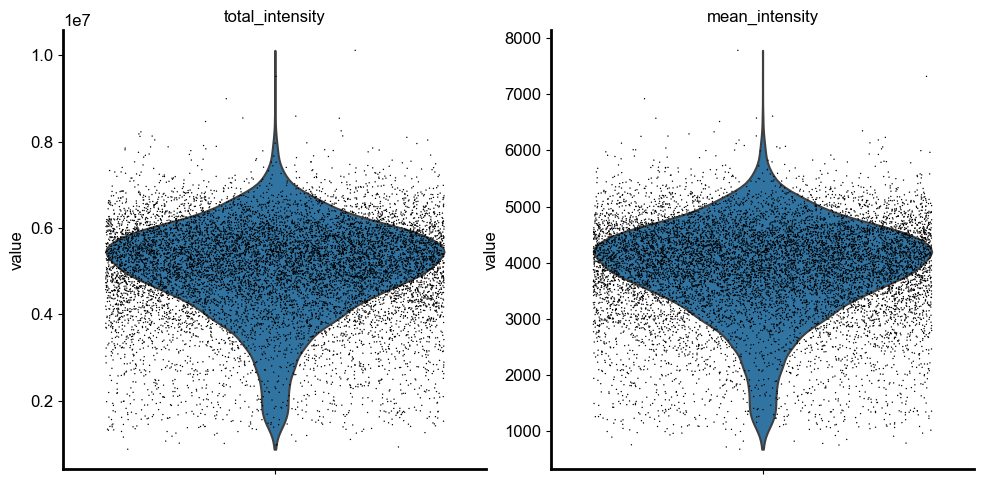

In [23]:
sc.pl.violin(
    adata_SM,
    ['total_intensity', 'mean_intensity'],
    jitter=0.4,
    multi_panel=True,
)

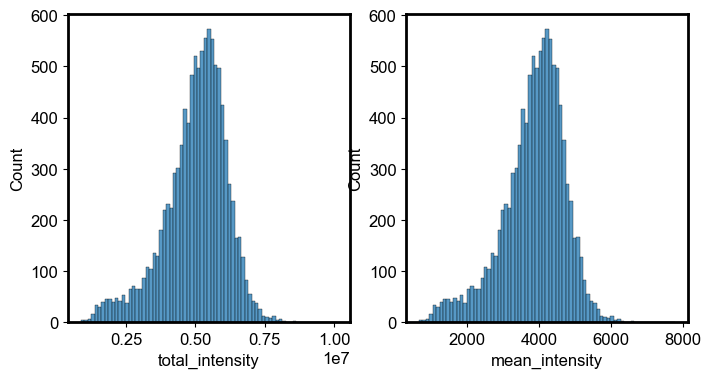

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(
    adata_SM.obs["total_intensity"], 
    kde=False, 
    ax=axs[0]
)
sns.histplot(
    adata_SM.obs["mean_intensity"],
    kde=False,
    ax=axs[1],
)
plt.show()

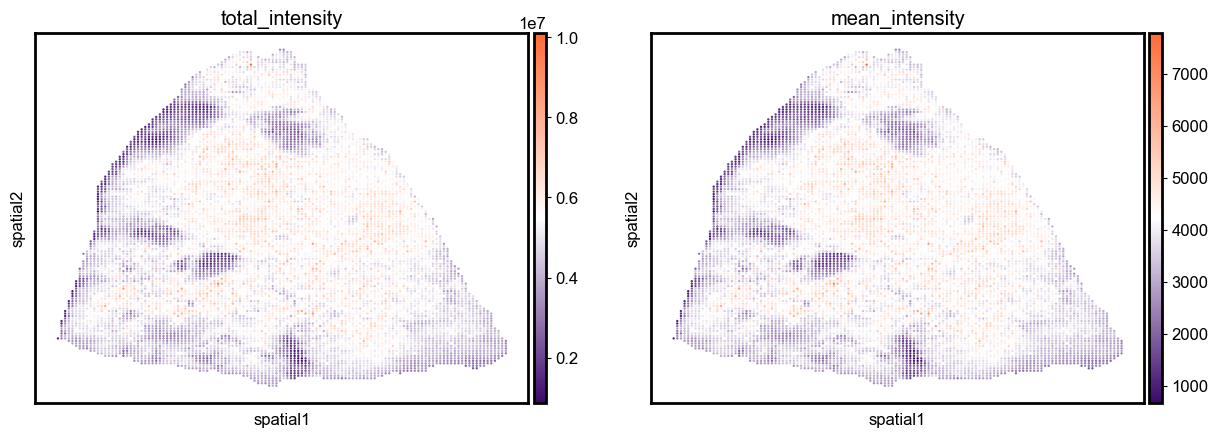

In [25]:
sc.pl.embedding(adata_SM,
                basis='spatial',
                cmap = make_colormap(['#3c096c','#FFFFFF','#ff6b35']),
                color=['total_intensity','mean_intensity'])

In [26]:
adata_SM = smt.pp.filter_cells_sm(adata_SM,min_total_intensity=2e6)

Filtered 234 cells with total intensity less than 2000000.0


### Quality Control for ST

Quality control for ST data can be performed using calculate_qc_metrics() provided by scanpy.

In [27]:
adata_ST.var["mt"] = adata_ST.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_ST, qc_vars=["mt"], inplace=True)

In [28]:
adata_ST

AnnData object with n_obs × n_vars = 2018 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

For human data, exclude genes associated with Heat Shock Proteins (HSP), Metallothioneins (MT), Ribosomal Proteins Large subunit (RPL), and DNAJ proteins using the removeHSP_MT_RPL_DNAJ() function, as they are not relevant for our analysis. For mouse data, use removeHsp_mt_Rpl_Dnaj() for the same purpose.

In [29]:
adata_ST = smt.pp.removeHSP_MT_RPL_DNAJ(adata_ST)

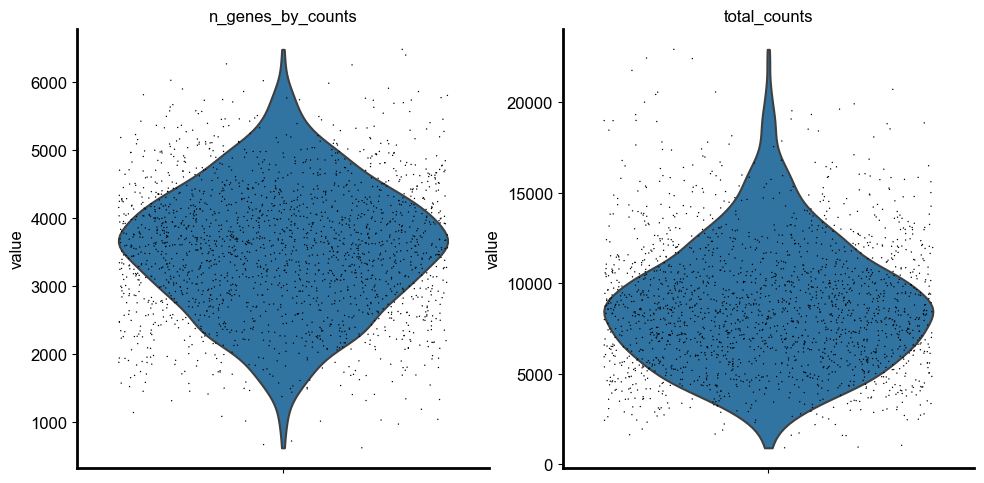

In [30]:
sc.pl.violin(
    adata_ST,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

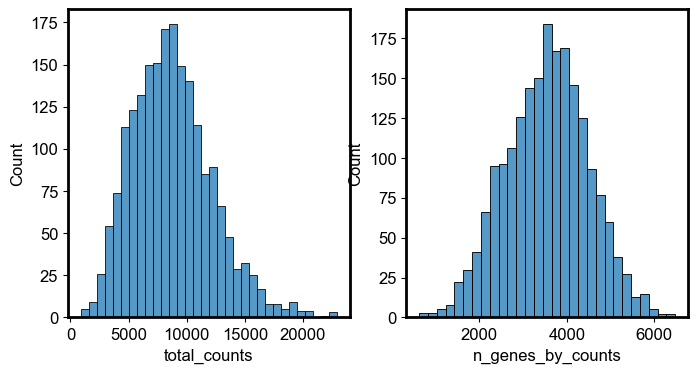

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(
    adata_ST.obs["total_counts"], 
    kde=False, 
    ax=axs[0]
)
sns.histplot(
    adata_ST.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)
plt.show()

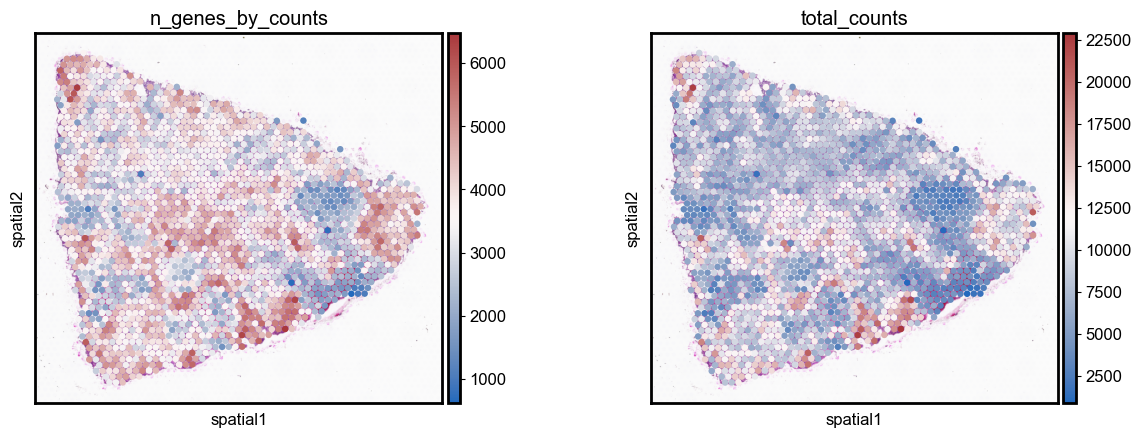

In [32]:
sc.pl.spatial(adata_ST, 
              img_key="hires", 
              color=["n_genes_by_counts", "total_counts"],
              edges_width=0,
              color_map = "vlag",
              size=1.5)

In [33]:
sc.pp.filter_cells(adata_ST,min_counts=3000)
sc.pp.filter_cells(adata_ST,min_genes=1000)

In [34]:
adata_SM.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_qc.h5ad")
adata_ST.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_ST_qc.h5ad")